# Imports

In [1]:
import os
import sys
import json

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt

import torch
from torchvision import transforms

sys.path.append("../")
from src.data.dataset import load_json
from src.pytorch.generator_data_loader import SpectogramDataset
from src.pytorch.drone_classification import get_resnet18_model

In [2]:
master_meta_path = '../data/Related work from Rowan/new_dataset/master_meta_data.json'
meta_data = load_json(master_meta_path)
data_paths = []
for item in meta_data:
    
    item['dat_file_path'] = item['dat_file_path'].replace('/mnt/d/Rowan/AeroDefence/data/', '/mnt/d/Rowan/AeroDefence/dataset/')

    data_paths.append(item['dat_file_path'])

unique_files = list(set(data_paths))
print(f"Total unique files: {len(unique_files)}")
missing_files = []
for file_path in unique_files:
    if not os.path.exists(file_path):
        missing_files.append(file_path)

if missing_files:
    print("\nThe following files are missing:")
    for f in missing_files:
        print(f)
else:
    print("\nAll files exist.")

with open('../dataset/master_meta_data.json', 'w') as f:
        json.dump(meta_data, f, indent=4)


Total unique files: 57

All files exist.


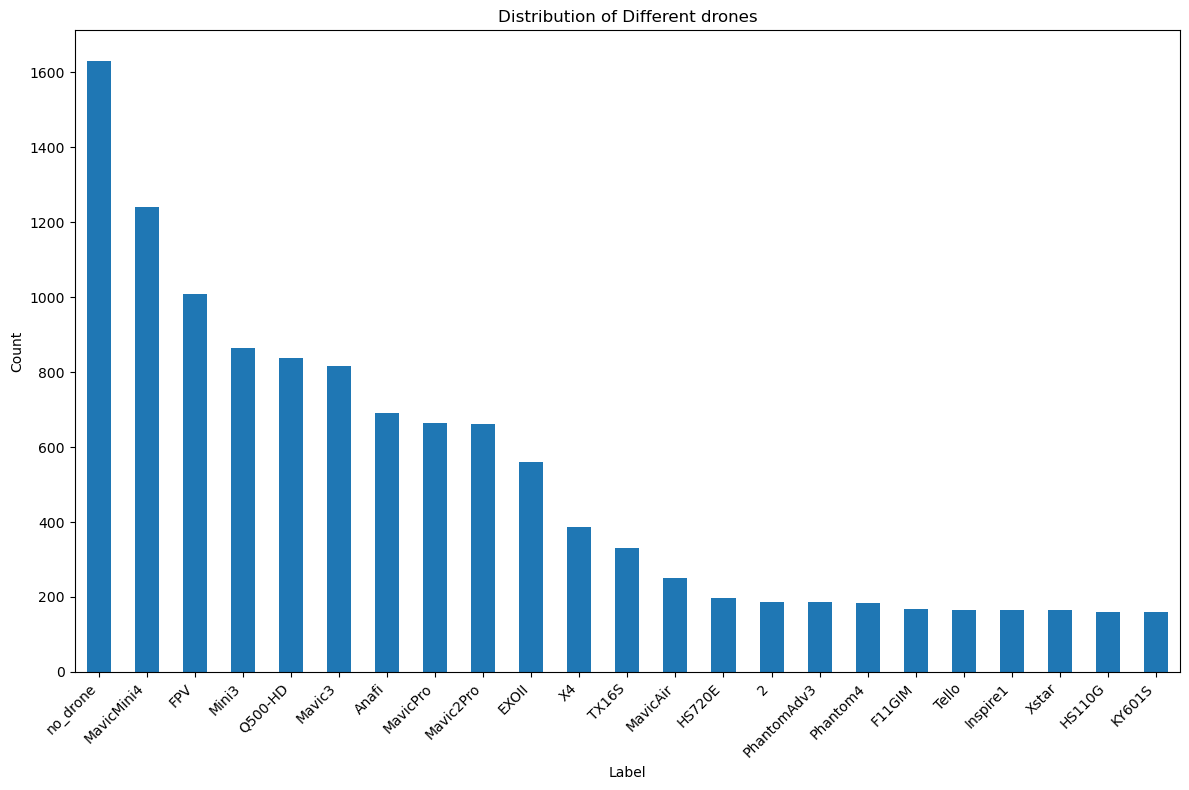

In [3]:
import pandas as pd

import matplotlib.pyplot as plt

# Create a DataFrame from meta_data
df_meta = pd.DataFrame(meta_data)

# Count occurrences of each label
label_counts = df_meta['label'].value_counts()

# Create a bar chart
plt.figure(figsize=(12, 8))
label_counts.plot(kind='bar')
plt.title('Distribution of Different drones')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [4]:
set(df_meta['label'])

{'2',
 'Anafi',
 'EXOII',
 'F11GIM',
 'FPV',
 'HS110G',
 'HS720E',
 'Inspire1',
 'KY601S',
 'Mavic2Pro',
 'Mavic3',
 'MavicAir',
 'MavicMini4',
 'MavicPro',
 'Mini3',
 'Phantom4',
 'PhantomAdv3',
 'Q500-HD',
 'TX16S',
 'Tello',
 'X4',
 'Xstar',
 'no_drone'}

In [3]:
import random
import json
from collections import defaultdict

# Group data by label
grouped_by_label = defaultdict(list)
for item in meta_data:
    grouped_by_label[item['label']].append(item)

# Sample 20 items from each label
sampled_meta_data = []
samples_per_label = 100

for label, items in grouped_by_label.items():
    if len(items) > samples_per_label:
        sampled_items = random.sample(items, samples_per_label)
    else:
        # If less than 20 samples, take all available
        sampled_items = items 
        print(f"Warning: Label '{label}' has only {len(items)} samples, taking all.")
    sampled_meta_data.extend(sampled_items)

# Shuffle the final list (optional, but good practice)
random.shuffle(sampled_meta_data)

# Define the path for the new metadata file
output_sampled_meta_path = '../dataset/sampled_master_meta_data.json' # Or your desired path

# Save the new sampled metadata
try:
    with open(output_sampled_meta_path, 'w') as f:
        json.dump(sampled_meta_data, f, indent=4)
    print(f"\nSuccessfully created sampled metadata file with {len(sampled_meta_data)} total entries.")
    print(f"Saved to: {output_sampled_meta_path}")
except IOError as e:
    print(f"Error saving file: {e}")

# You can print the counts per label in the new dataset to verify
final_counts = defaultdict(int)
for item in sampled_meta_data:
    final_counts[item['label']] += 1
print("\nCounts per label in the new sampled dataset:")
for label, count in final_counts.items():
    print(f"- {label}: {count}")


Successfully created sampled metadata file with 2300 total entries.
Saved to: ../dataset/sampled_master_meta_data.json

Counts per label in the new sampled dataset:
- Q500-HD: 100
- Mini3: 100
- PhantomAdv3: 100
- MavicMini4: 100
- FPV: 100
- EXOII: 100
- Tello: 100
- Xstar: 100
- no_drone: 100
- F11GIM: 100
- HS110G: 100
- Phantom4: 100
- KY601S: 100
- Anafi: 100
- Mavic3: 100
- 2: 100
- X4: 100
- MavicAir: 100
- TX16S: 100
- Inspire1: 100
- MavicPro: 100
- Mavic2Pro: 100
- HS720E: 100


In [4]:
def load_model(model_path, num_classes, device):
    """
    Load the trained model from a file.
    
    Args:
        model_path (str): Path to the saved model
        device (torch.device): Device to load the model on
    
    Returns:
        model: The loaded model
    """
    model = get_resnet18_model(num_classes=num_classes).to(device)
    
    # If model was saved as DataParallel, we need to handle that
    state_dict = torch.load(model_path, map_location=device)
    if list(state_dict.keys())[0].startswith('module.'):
        # Model was saved using DataParallel
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:]  # remove 'module.'
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)
    else:
        model.load_state_dict(state_dict)
    
    return model


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the trained model
model = load_model(model_path='../models/best_resnet18_drones_moe.pth', num_classes=23, device=device)
print(f"Model loaded from ../models/best_resnet18_drones_moe_2.pth")

# Define transforms
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

Using device: cuda
Model loaded from ../models/best_resnet18_drones_moe_2.pth


In [20]:
from matplotlib.font_manager import json_load
from torch.utils.data import random_split

dataset = SpectogramDataset(master_meta_data_path='../dataset/sampled_master_meta_data.json',
                 snr_list=[0, -5, -10],
                 fft_size=1024, num_fft_spec=1500,
                 stft_overlap=128,
                 mode='label',
                 background_list=['no_drone'],
                 transform=test_transform) # Use the test_transform defined in the previous cell

label_mappings = json_load('../exp/cm_drones_moe_2/label_mappings.json')
dataset.int_to_label = label_mappings['int_to_label']
dataset.label_to_int = label_mappings['label_to_int']
dataset.classes = label_mappings['classes']


data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=22, pin_memory=True)


Evaluating: 100%|██████████| 72/72 [03:34<00:00,  2.98s/it] 


Evaluation Metrics:
Accuracy: 0.4235
Precision (weighted): 0.5336
Recall (weighted): 0.4235
F1-score (weighted): 0.3916


{'accuracy': 0.4234782608695652,
 'precision': 0.53357814758936,
 'recall': 0.4234782608695652,
 'f1': 0.3916088199133944}

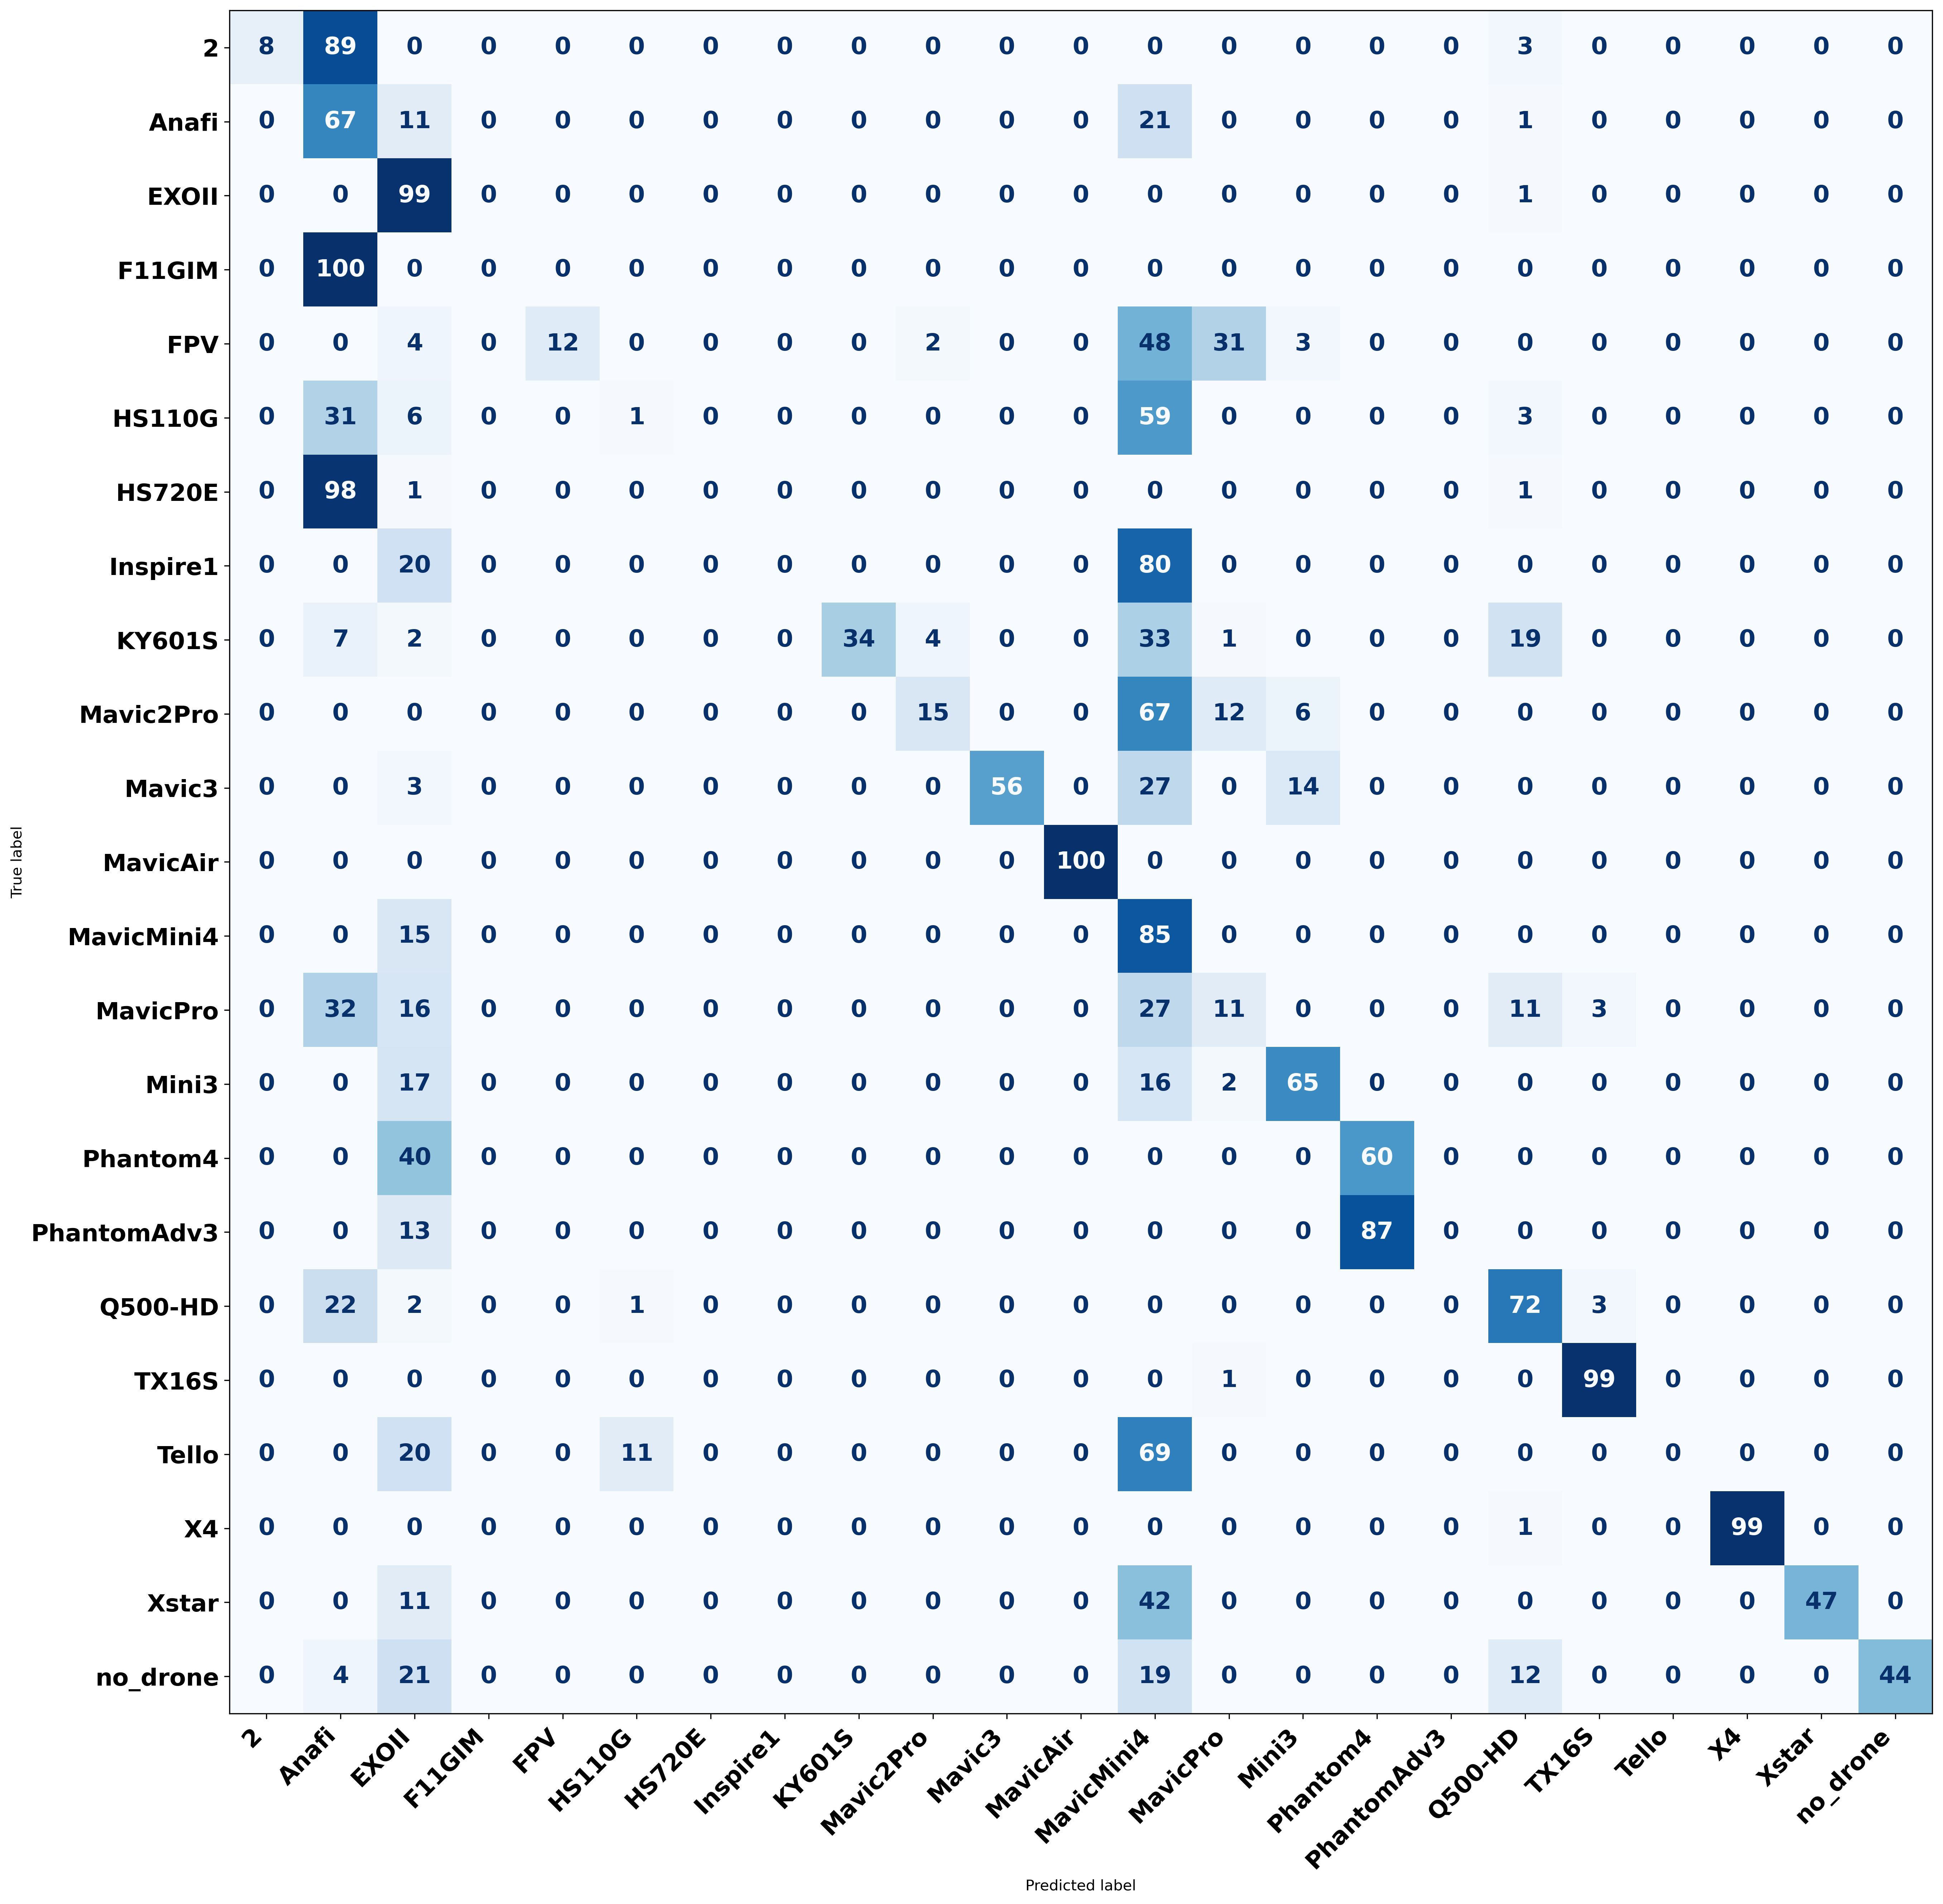

In [ ]:
def evaluate_model(model, test_loader, device, output_dir=None):
    """
    Evaluate the model on test data
    
    Args:
        model: The model to evaluate
        test_loader: DataLoader containing test data
        device: Device to run evaluation on
        output_dir (str, optional): Directory to save evaluation results
        
    Returns:
        dict: Dictionary containing evaluation metrics
    """
    model.eval()
    all_labels = []
    all_preds = []
    # all_probs = [] # This line might need adjustment if you use it for multiclass ROC/AUC later

    class_names = test_loader.dataset.classes # Get class names from the dataset
    

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # probabilities = torch.softmax(outputs, dim=1) # Probabilities for all classes
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            # all_probs.extend(probabilities.cpu().numpy()) # Store all probabilities if needed
    
    # Calculate metrics
    metrics = {
        "accuracy": accuracy_score(all_labels, all_preds),
        "precision": precision_score(all_labels, all_preds, average='weighted', zero_division=0),
        "recall": recall_score(all_labels, all_preds, average='weighted', zero_division=0),
        "f1": f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    }
    
    # Create and save confusion matrix if output_dir is provided
    if output_dir:
        labelsize = 16
        os.makedirs(output_dir, exist_ok=True)
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

        # Adjust figure size dynamically, ensure it's large enough for bold text
        fig_width = max(10, len(class_names) * 0.8) # Increased base width and scaling factor
        fig_height = max(10, len(class_names) * 0.8) # Increased base height and scaling factor
        fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)

        disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical', colorbar=False, text_kw={'fontsize': labelsize, 'fontweight': 'bold'}) # Adjust text_kw for cell text

        # Increase font size and make bold for x and y tick labels
        ax.tick_params(axis='x', labelsize=labelsize, labelfontfamily='sans-serif', labelcolor='black') # fontweight doesn't work directly here, use setp
        ax.tick_params(axis='y', labelsize=labelsize, labelfontfamily='sans-serif', labelcolor='black') # fontweight doesn't work directly here, use setp

        plt.setp(ax.get_xticklabels(), fontweight="bold")
        plt.setp(ax.get_yticklabels(), fontweight="bold")

        if len(class_names) > 6:
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
            plt.setp(ax.get_yticklabels(), rotation=0) # Keep y-axis labels horizontal or adjust as needed
        
        plt.tight_layout(pad=2.0) # Add some padding
                
        # Print metrics
        print(f"\nEvaluation Metrics:")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision (weighted): {metrics['precision']:.4f}")
        print(f"Recall (weighted): {metrics['recall']:.4f}")
        print(f"F1-score (weighted): {metrics['f1']:.4f}")
        
        # Save metrics to a text file
        with open(os.path.join(output_dir, "metrics.txt"), "w") as f:
            for metric_name, metric_value in metrics.items():
                f.write(f"{metric_name}: {metric_value:.4f}\n")
    
    return metrics


evaluate_model(model, data_loader, device, output_dir='../exp/evaluation_results_2')

NameError: name 'all_labels' is not defined